# Data Analysis of Audio MNIST Dataset

## Libraries

In [39]:
import sys
import IPython
from IPython.display import Audio
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.io import wavfile
from sklearn.preprocessing import scale

## The Data

The dataset comes from the [Audio MNIST](https://github.com/soerenab/AudioMNIST/tree/master/recording_scripts) dataset created by Becker et. al. for their paper ["Interpreting and Explaining Deep Neural Networks for Classification of Audio Signals"](https://arxiv.org/abs/1807.03418). It contains 30,000 audio samples, evenly distributed from 0-9, spoken by 60 different speakers.

## Example Data
A look at a single audio file to see the type of structure being worked with. This will primarily use the library librosa, but the model itself will use PyTorch's own audio libraries.

In [3]:
AUDIO_FILE = 'data/test_audio/test_zero.wav'
samples, sample_rate = librosa.load(AUDIO_FILE, sr=None)

### Building a Mel Spectrogram to visualize the audio
Because of the unique nature of audio data, the easiest and oftentimes best way to build a model for it is to create a spectrogram, a visual representation of the audio, to then pass into a model as you would any other image dataset.

The [Mel Spectrogram](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53) uses a Fourier Transformation and then scales the audio to fit within the Mel Scale, which gives a much clearer and workable spectrogram to model off of.

c:\users\sourp\appdata\local\programs\python\python38\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
c:\users\sourp\appdata\local\programs\python\python38\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


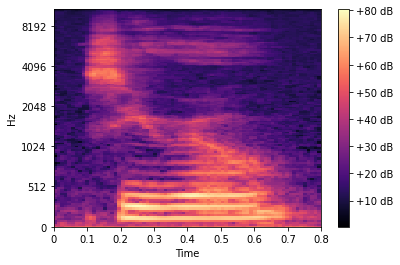

In [4]:
sgram = librosa.stft(samples)
sgram_mag, _ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)

mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)

librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time',y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.show()

### Transforming the Mel Spectrogram further
The MS can be made even more effective for human speech by scaling it to focus on the range of specific frequencies most commonly used in human speech. Librosa has a built in library for this.

c:\users\sourp\appdata\local\programs\python\python38\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
c:\users\sourp\appdata\local\programs\python\python38\lib\site-packages\sklearn\preprocessing\_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


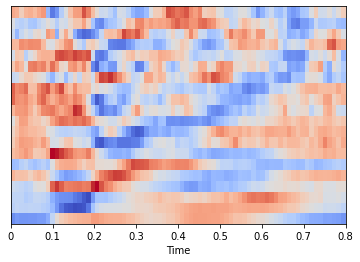

In [7]:
mfcc = librosa.feature.mfcc(samples, sr=sample_rate)
mfcc = scale(mfcc, axis=1)
librosa.display.specshow(mfcc, sr=sample_rate, x_axis='time')

plt.show()

In [8]:
sample_rate

48000

## Examing all audio files and labels

In [9]:
def get_audio_files(path):
	files = []
	for i in range(60):
		speaker = i+1
		if speaker < 10:
			speaker = f'0{speaker}'
		else:
			speaker = f'{speaker}'

		new_path = f'{path}{speaker}/'
		new_files = [f'{speaker}/{f}' for f in os.listdir(new_path)]

		files += new_files

	df = pd.DataFrame({'relative_path':files,'classID':[int(f.split('/')[-1].split('_')[0]) for f in files]})

	return df

In [14]:
df = get_audio_files('F:/audio/audio_mnist/data/')

In [16]:
df.head()

,relative_path,classID
0,01/0_01_0.wav,0
1,01/0_01_1.wav,0
2,01/0_01_10.wav,0
3,01/0_01_11.wav,0
4,01/0_01_12.wav,0


### Examing the label breakdowns
The dataset itself was made specifically as an MNIST dataset, meaning care was taken to ensure uniform label distribution, as seen below.

In [17]:
df.classID.describe()

count    30000.000000
mean         4.500000
std          2.872329
min          0.000000
25%          2.000000
50%          4.500000
75%          7.000000
max          9.000000
Name: classID, dtype: float64

<AxesSubplot:>

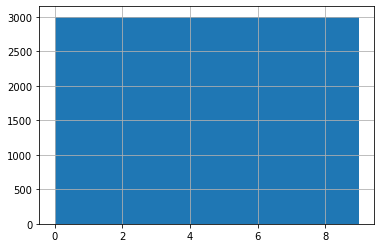

In [18]:
df.classID.hist()

### Examing sample rates
Sample rates are the number of samples per second that an audio file produces. For example, if a sample rate was 100, then there would be 100 rows of data per second of audio. Ensuring uniform sample rates is key to accurate modeling.

In [25]:
path = 'F:/audio/audio_mnist/data/'
sample_rates = []
sample_lens = []
for file in df.relative_path.values:
    full_path = path+file
    samples, sample_rate = librosa.load(full_path, sr=None)
    sample_lens.append(len(samples))
    sample_rates.append(sample_rate)

In [23]:
unique_rates = {}
for i in sample_rates:
    if str(i) not in unique_rates.keys():
        unique_rates[str(i)] = 1
    else:
        unique_rates[str(i)] += 1

In [24]:
unique_rates

{'48000': 30000}

### Examining clip lengths
Much like sample rates, the length of the clips should be uniform to accurately perform modeling. Examining will help determine the amount of padding required.

In [30]:
path = 'F:/audio/audio_mnist/data/'
clip_lens = []
for file in df.relative_path.values:
    duration = librosa.get_duration(filename=path+file)
    clip_lens.append(duration)

In [31]:
unique_lengths = {}
for i in clip_lens:
    if str(i) not in unique_lengths.keys():
        unique_lengths[str(i)] = 1
    else:
        unique_lengths[str(i)] += 1

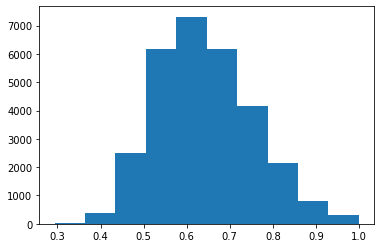

In [33]:
plt.hist(clip_lens)
plt.show()

All the clips are <= 1 second long and by random samples of the audio itself, we can infer this is mosly due to the length of speaking the number, as there is very little background noise or padding on either side of the clip.

In [48]:
path = 'F:/audio/audio_mnist/data/'
full_paths = []
for file in df.relative_path.values:
    full_path = path+file
    full_paths.append(full_path)

In [49]:
for i in range(10):
    path = random.choice(full_paths)
    IPython.display.display(Audio(filename=path, rate=48000))

#### Clip length by label
Checking to see if there is a pattern of clip length by label, as that could break the model.

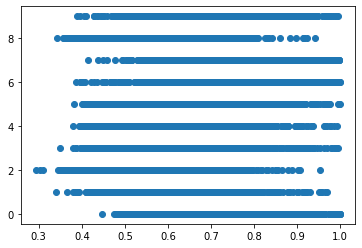

In [50]:
plt.scatter(clip_lens, df.classID.values)

In [52]:
df['length'] = clip_lens

In [54]:
for i in range(10):
    print(df.loc[df.classID.eq(i), 'length'].mean())

0.7105076458333333
0.5917147986111111
0.5551640763888889
0.6033804097222222
0.6094982083333335
0.6330892222222222
0.7331245902777778
0.7353945138888888
0.5857460138888888
0.6683129236111112


While some numbers (such as "seven"'s two syllbles) are on average longer than others. There doesn't seem to be enough skewness for any single number that cannot be fixed with some padding during data prep.